In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import math
import sweetviz as sv
from tabulate import tabulate
import seaborn as sns
import os
import time
import sklearn
import lightgbm as lgb
from sklearn.cluster import KMeans
from sklearn.model_selection import GroupKFold
from sklearn import metrics
from sklearn.model_selection import GroupKFold, RepeatedKFold, KFold

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
print('pandas_version ' + pd.__version__)
print('scikit_learn_version ' + sklearn.__version__)
print('lightgbm_version ' +lgb.__version__)

pandas_version 1.4.2
scikit_learn_version 1.1.3
lightgbm_version 3.3.3


In [3]:
## Machine learning model
from lightgbm import LGBMRegressor

## Loading Data

In [4]:
train = pd.read_csv("train_IxoE5JN.csv")
test = pd.read_csv("test_WudNWDM.csv")
sample_sub = pd.read_csv("sample_submission_jn0a7vR.csv")

train.shape, test.shape, sample_sub.shape

((94992, 3), (26304, 2), (26304, 2))

In [8]:
sample_sub.head()

,row_id,energy
0,94993,1702.995014
1,94994,1702.995014
2,94995,1702.995014
3,94996,1702.995014
4,94997,1702.995014


In [5]:
train.head()

,row_id,datetime,energy
0,1,2008-03-01 00:00:00,1259.985563
1,2,2008-03-01 01:00:00,1095.541500
2,3,2008-03-01 02:00:00,1056.247500
3,4,2008-03-01 03:00:00,1034.742000
4,5,2008-03-01 04:00:00,1026.334500


In [6]:
#convert to datetime object
train['datetime'] = pd.to_datetime(train['datetime'])
train['datetime'].dt.date.value_counts()#.sort_index()

2008-03-01    24
2015-05-13    24
2015-05-15    24
2015-05-16    24
2015-05-17    24
              ..
2011-10-15    24
2011-10-16    24
2011-10-17    24
2011-10-18    24
2018-12-31    24
Name: datetime, Length: 3958, dtype: int64

In [7]:
#convert to datetime object
test['datetime'] = pd.to_datetime(test['datetime'])
test['datetime'].dt.date.value_counts().sort_index()

2019-01-01    24
2019-01-02    24
2019-01-03    24
2019-01-04    24
2019-01-05    24
              ..
2021-12-27    24
2021-12-28    24
2021-12-29    24
2021-12-30    24
2021-12-31    24
Name: datetime, Length: 1096, dtype: int64

In [9]:
def quality_report(df):
    """
    Description: Displays quality of data in terms of missing values, 
    unique numbers, datatypes etc.
    
    Arguments: Dataframe
    """
    dtypes = df.dtypes
    nuniq = df.T.apply(lambda x: x.nunique(), axis=1)
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    quality_df  = pd.concat([total, percent, nuniq, dtypes], axis=1, keys=['Total NaN', 'Percent of NaN','Nunique', 'Dtype'])
    display(quality_df)


# EDA : Try to check for Seasonalities found:
- Yearly
- Weekly
- Hourly


In [10]:
quality_report(train)

,Total NaN,Percent of NaN,Nunique,Dtype
energy,1900,2.000168,61308,float64
row_id,0,0.000000,94992,int64
datetime,0,0.000000,94992,datetime64[ns]


There is 2% Null values in Train data which needed to be filled

In [11]:
quality_report(test)

,Total NaN,Percent of NaN,Nunique,Dtype
row_id,0,0.0,26304,int64
datetime,0,0.0,26304,datetime64[ns]


## Energy Variable Distribution

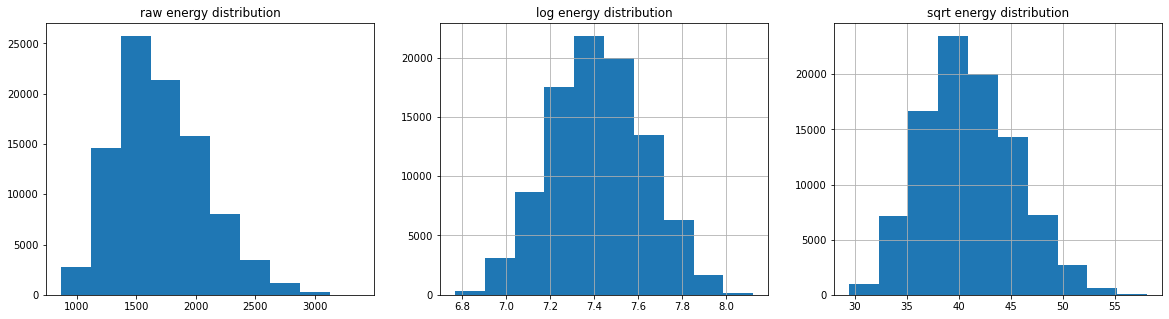

In [12]:
plt.figure(figsize = [20, 5]) 

plt.subplot(1, 3, 1) 
plt.hist(data = train, x = 'energy');

plt.title('raw energy distribution')
plt.subplot(1, 3, 2)
np.log1p(train['energy']).hist();

plt.title('log energy distribution')
plt.subplot(1, 3, 3)
np.sqrt(train['energy']).hist();
plt.title('sqrt energy distribution');

In [13]:
train['datetime'].unique()

array(['2008-03-01T00:00:00.000000000', '2008-03-01T01:00:00.000000000',
       '2008-03-01T02:00:00.000000000', ...,
       '2018-12-31T21:00:00.000000000', '2018-12-31T22:00:00.000000000',
       '2018-12-31T23:00:00.000000000'], dtype='datetime64[ns]')

In [14]:
test['datetime'].unique()

array(['2019-01-01T00:00:00.000000000', '2019-01-01T01:00:00.000000000',
       '2019-01-01T02:00:00.000000000', ...,
       '2021-12-31T21:00:00.000000000', '2021-12-31T22:00:00.000000000',
       '2021-12-31T23:00:00.000000000'], dtype='datetime64[ns]')

In [15]:
train['energy'].describe().round(3)

count    93092.000
mean      1702.995
std        369.322
min        866.389
25%       1431.541
50%       1654.466
75%       1935.993
max       3374.400
Name: energy, dtype: float64

 I observe 0% of the energy values are 866.389.

## Complete Time Series in the train Dataset

<AxesSubplot:xlabel='datetime'>

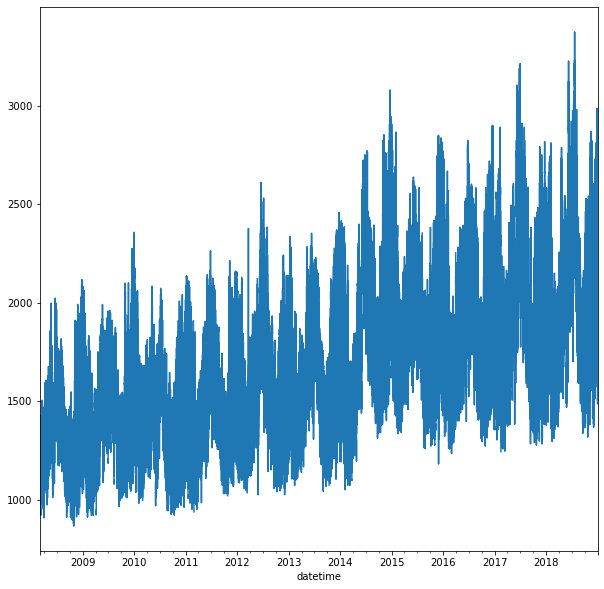

In [16]:
train[['datetime','energy']].set_index('datetime')['energy'].plot(figsize=(10,10))

<AxesSubplot:xlabel='datetime'>

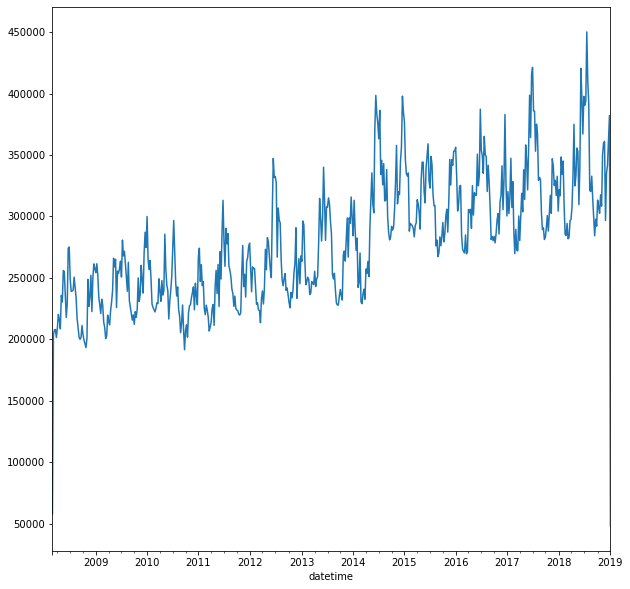

In [17]:
train[['datetime','energy']].set_index('datetime')['energy'].resample('W').sum().plot(figsize=(10,10)) #plotting a new dataframe created namely  Week with sum  of energy 

## FEATURE ENGINEERING 

In [21]:
## Extracting day of year attached with hour 
train['doy_h'] = train['datetime'].dt.dayofyear.astype(str).str.zfill(3) + '|' + train['datetime'].dt.hour.astype(str).str.zfill(2)
train['year'] = train['datetime'].dt.year # extracting year from the datetime
train.head()

,row_id,datetime,energy,doy_h,year
0,1,2008-03-01 00:00:00,1259.985563,061|00,2008
1,2,2008-03-01 01:00:00,1095.541500,061|01,2008
2,3,2008-03-01 02:00:00,1056.247500,061|02,2008
3,4,2008-03-01 03:00:00,1034.742000,061|03,2008
4,5,2008-03-01 04:00:00,1026.334500,061|04,2008


<AxesSubplot:xlabel='doy_h'>

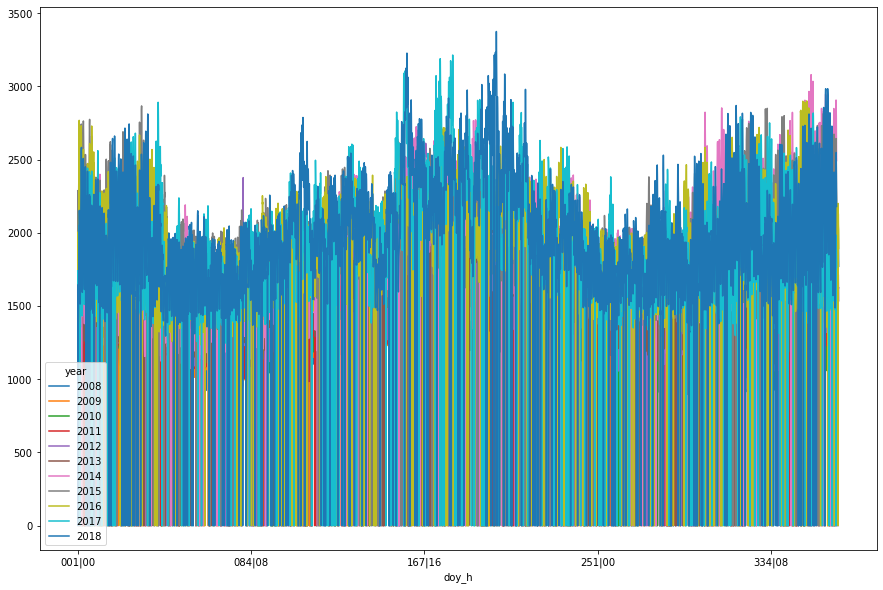

In [22]:
yoy = train.groupby(['doy_h','year'])['energy'].sum().unstack()# creating a yoy(year of year) by group day of year with each hour and year by energy and unstack it so as to derive more information from it
yoy.plot(figsize=(15,10))

In [23]:
train.head()

,row_id,datetime,energy,doy_h,year
0,1,2008-03-01 00:00:00,1259.985563,061|00,2008
1,2,2008-03-01 01:00:00,1095.541500,061|01,2008
2,3,2008-03-01 02:00:00,1056.247500,061|02,2008
3,4,2008-03-01 03:00:00,1034.742000,061|03,2008
4,5,2008-03-01 04:00:00,1026.334500,061|04,2008


In [24]:
yoy # The reason why there are nan values is cos of the missing values in the energy column 

year,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
doy_h,,,,,,,,,,,
001|00,NaN,1610.2674,1907.1104,1593.3183,1649.2750,1410.8836,1812.7928,2287.2788,2002.2470,1740.5604,1642.7628
001|01,NaN,1471.4406,1771.7830,1469.9586,1517.2775,1321.0386,1668.4780,2120.5124,1843.3870,1618.2288,0.0000
001|02,NaN,1371.6864,1658.2826,1382.3418,1436.1550,1255.9274,1583.9404,2015.9704,1735.1178,1534.7286,1463.6552
001|03,NaN,1301.6556,1584.3555,1326.2229,1377.0475,1223.9003,1517.9472,1939.9740,1666.1970,1480.2885,1413.1208
001|04,NaN,1273.5198,1530.2625,1294.8099,1334.0350,1203.3945,1476.0928,1885.3868,1630.3924,1452.6243,1385.8796
...,...,...,...,...,...,...,...,...,...,...,...
366|19,2027.2770,NaN,NaN,NaN,1711.1773,NaN,NaN,NaN,2129.7627,NaN,NaN
366|20,1968.6240,NaN,NaN,NaN,1659.3843,NaN,NaN,NaN,2056.2876,NaN,NaN
366|21,1927.0818,NaN,NaN,NaN,1621.4380,NaN,NaN,NaN,2022.5322,NaN,NaN


<AxesSubplot:xlabel='doy_h'>

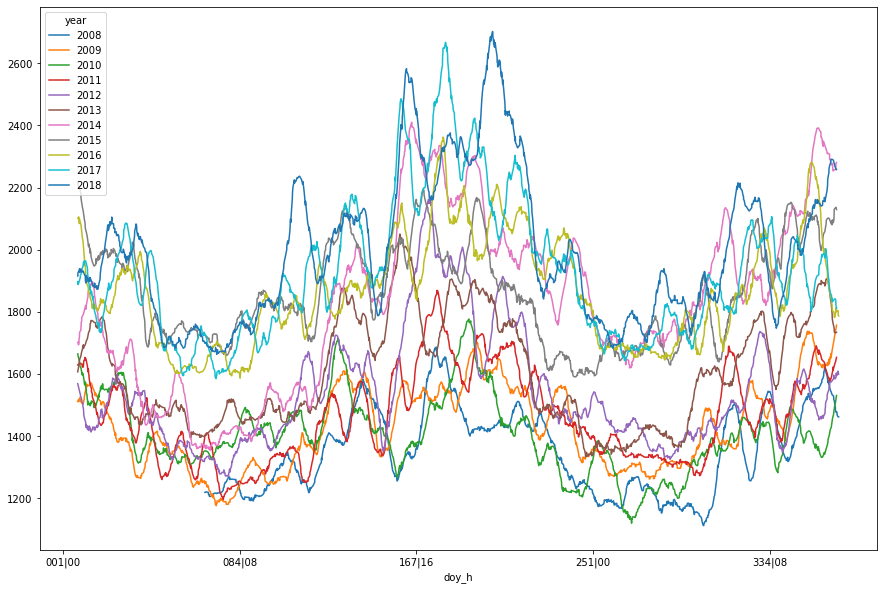

In [25]:
yoy.rolling(24*7).mean().loc[:,:].plot(figsize=(15,10))  # calculating the rolling mean of yoy using 24 hours a day in 7 days a week

## YoY(YEAR ON YEAR) DoM : Creating a new colum called Day of Month DoM

In [380]:
8//7

1

<AxesSubplot:xlabel='dom'>

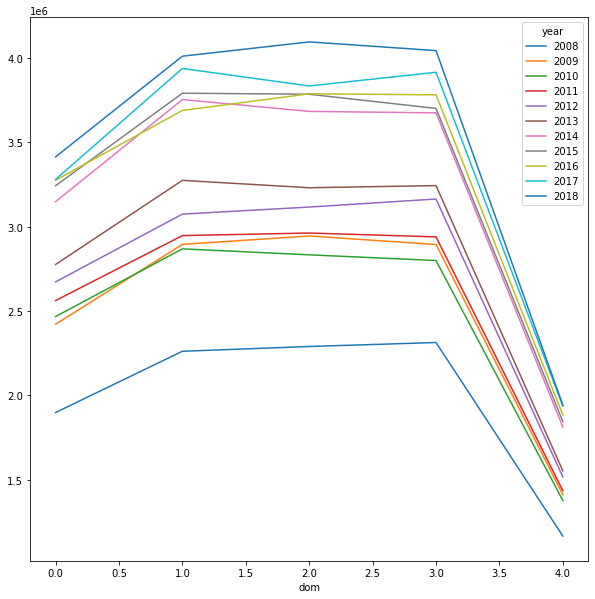

In [26]:
train['dom'] = train['datetime'].dt.day//7

train.groupby(['dom','year'])['energy'].sum().unstack().plot(figsize=(10,10))

## YoY DoW: CREATING DAY OF WEEK COLUMN 

In [27]:
train['dow'] = train['datetime'].dt.dayofweek

<AxesSubplot:xlabel='dow'>

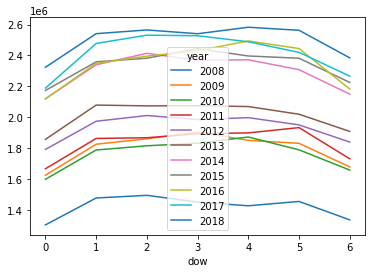

In [28]:
train.groupby(['dow','year'])['energy'].sum().unstack().plot()

## YoY MoY: CREATING MONTH OF WEEK

<AxesSubplot:xlabel='month'>

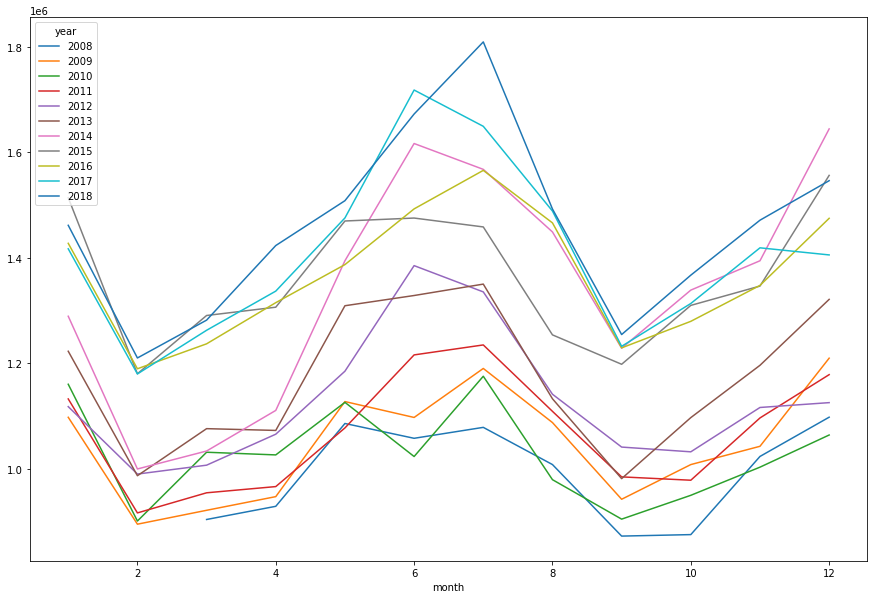

In [29]:
train['month'] = train['datetime'].dt.month
yoy = train.groupby(['month','year'])['energy'].sum().unstack()# creating a yoy(year on year) by group month and year by energy and unstack it so as to derive more information from it
yoy.plot(figsize=(15,10))

In [30]:
yoy # The reason why there are nan values is cos of the missing values in the energy column 

year,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
month,,,,,,,,,,,
1,NaN,1.097660e+06,1.160245e+06,1.132423e+06,1.117823e+06,1.222795e+06,1.289157e+06,1.513836e+06,1.427396e+06,1.416982e+06,1.461525e+06
2,NaN,8.950083e+05,9.009759e+05,9.163941e+05,9.900306e+05,9.869065e+05,9.996684e+05,1.180119e+06,1.189606e+06,1.179799e+06,1.210071e+06
3,9.039156e+05,9.213476e+05,1.031392e+06,9.545074e+05,1.006875e+06,1.076096e+06,1.033698e+06,1.290583e+06,1.236880e+06,1.262562e+06,1.281786e+06
4,9.288909e+05,9.472536e+05,1.026329e+06,9.662874e+05,1.065587e+06,1.072724e+06,1.110661e+06,1.306311e+06,1.314904e+06,1.336786e+06,1.423164e+06
5,1.085890e+06,1.127434e+06,1.125962e+06,1.077491e+06,1.185006e+06,1.309080e+06,1.394385e+06,1.469697e+06,1.387060e+06,1.475493e+06,1.508187e+06
6,1.057816e+06,1.097324e+06,1.023275e+06,1.215882e+06,1.385104e+06,1.328461e+06,1.616558e+06,1.475280e+06,1.492652e+06,1.717932e+06,1.672476e+06
7,1.078533e+06,1.190189e+06,1.175417e+06,1.234778e+06,1.335297e+06,1.350075e+06,1.567566e+06,1.458446e+06,1.565644e+06,1.649171e+06,1.809148e+06
8,1.008029e+06,1.087627e+06,9.793890e+05,1.108908e+06,1.141360e+06,1.132738e+06,1.448933e+06,1.253849e+06,1.466118e+06,1.488550e+06,1.492413e+06
9,8.724509e+05,9.422665e+05,9.045873e+05,9.846841e+05,1.041174e+06,9.813673e+05,1.228592e+06,1.198125e+06,1.229217e+06,1.232157e+06,1.254471e+06


In [31]:
train.groupby(['month','year'])['energy'].sum().unstack()

year,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
month,,,,,,,,,,,
1,NaN,1.097660e+06,1.160245e+06,1.132423e+06,1.117823e+06,1.222795e+06,1.289157e+06,1.513836e+06,1.427396e+06,1.416982e+06,1.461525e+06
2,NaN,8.950083e+05,9.009759e+05,9.163941e+05,9.900306e+05,9.869065e+05,9.996684e+05,1.180119e+06,1.189606e+06,1.179799e+06,1.210071e+06
3,9.039156e+05,9.213476e+05,1.031392e+06,9.545074e+05,1.006875e+06,1.076096e+06,1.033698e+06,1.290583e+06,1.236880e+06,1.262562e+06,1.281786e+06
4,9.288909e+05,9.472536e+05,1.026329e+06,9.662874e+05,1.065587e+06,1.072724e+06,1.110661e+06,1.306311e+06,1.314904e+06,1.336786e+06,1.423164e+06
5,1.085890e+06,1.127434e+06,1.125962e+06,1.077491e+06,1.185006e+06,1.309080e+06,1.394385e+06,1.469697e+06,1.387060e+06,1.475493e+06,1.508187e+06
6,1.057816e+06,1.097324e+06,1.023275e+06,1.215882e+06,1.385104e+06,1.328461e+06,1.616558e+06,1.475280e+06,1.492652e+06,1.717932e+06,1.672476e+06
7,1.078533e+06,1.190189e+06,1.175417e+06,1.234778e+06,1.335297e+06,1.350075e+06,1.567566e+06,1.458446e+06,1.565644e+06,1.649171e+06,1.809148e+06
8,1.008029e+06,1.087627e+06,9.793890e+05,1.108908e+06,1.141360e+06,1.132738e+06,1.448933e+06,1.253849e+06,1.466118e+06,1.488550e+06,1.492413e+06
9,8.724509e+05,9.422665e+05,9.045873e+05,9.846841e+05,1.041174e+06,9.813673e+05,1.228592e+06,1.198125e+06,1.229217e+06,1.232157e+06,1.254471e+06


## YoY Quarterly

<AxesSubplot:xlabel='quarter'>

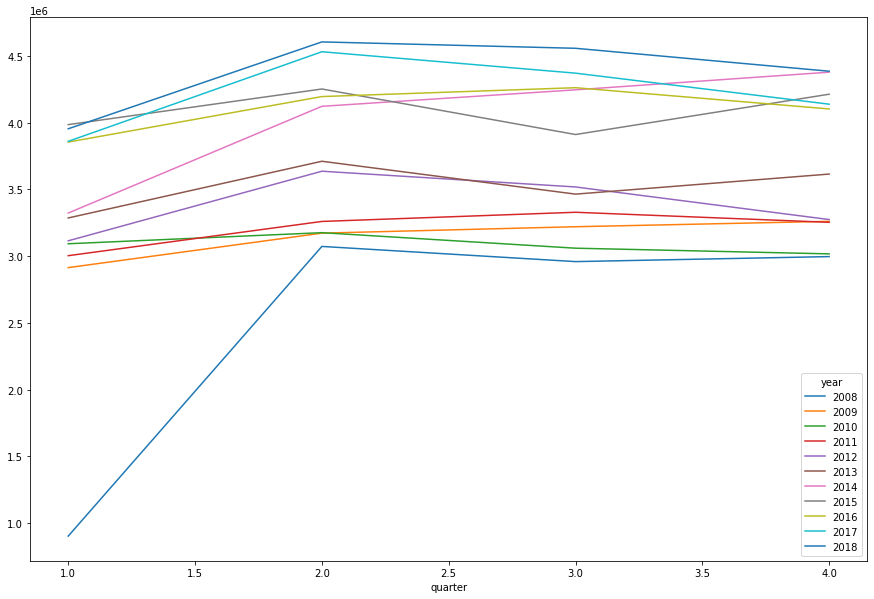

In [14]:
train['quarter'] = train['datetime'].dt.quarter #Extracting the quarter of the year
yoy = train.groupby(['quarter','year'])['energy'].sum().unstack() # creating a yoy(year on year) by group quarter and year by energy and unstack it so as to derive more information from it
yoy.plot(figsize=(15,10))

## YoY Hourly

In [32]:
train['hour'] = train['datetime'].dt.hour #Extrating the hour colum

<AxesSubplot:xlabel='hour'>

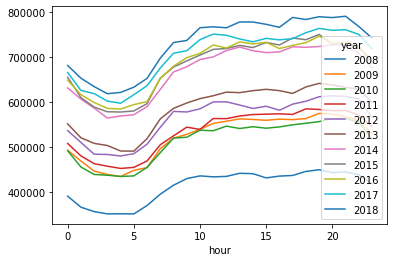

In [33]:
train.groupby(['hour','year'])['energy'].sum().unstack().plot()

In [34]:
train['date'] = train['datetime'].dt.date #Creating new date column in the  traindataframe 

In [35]:
train['daily_energy'] = train['date'].map(train.groupby('date')['energy'].sum()) # creating a new column called daily_energy which is the sum energy generated daily by date grouping
train

,row_id,datetime,energy,doy_h,year,dom,dow,month,hour,date,daily_energy,dth_ratio
0,1,2008-03-01 00:00:00,1259.985563,061|00,2008,0,5,3,0,2008-03-01,30336.129562,0.041534
1,2,2008-03-01 01:00:00,1095.541500,061|01,2008,0,5,3,1,2008-03-01,30336.129562,0.036113
2,3,2008-03-01 02:00:00,1056.247500,061|02,2008,0,5,3,2,2008-03-01,30336.129562,0.034818
3,4,2008-03-01 03:00:00,1034.742000,061|03,2008,0,5,3,3,2008-03-01,30336.129562,0.034109
4,5,2008-03-01 04:00:00,1026.334500,061|04,2008,0,5,3,4,2008-03-01,30336.129562,0.033832
...,...,...,...,...,...,...,...,...,...,...,...,...
94987,94988,2018-12-31 19:00:00,2528.446800,365|19,2018,4,0,12,19,2018-12-31,48053.720000,0.052617
94988,94989,2018-12-31 20:00:00,2461.883600,365|20,2018,4,0,12,20,2018-12-31,48053.720000,0.051232
94989,94990,2018-12-31 21:00:00,2365.994400,365|21,2018,4,0,12,21,2018-12-31,48053.720000,0.049236
94990,94991,2018-12-31 22:00:00,2342.942800,365|22,2018,4,0,12,22,2018-12-31,48053.720000,0.048757


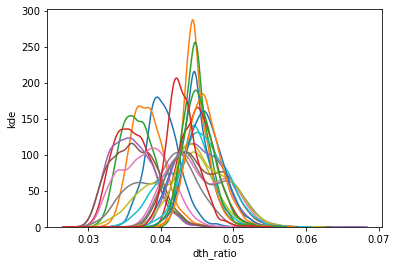

In [36]:
train.groupby('hour')['dth_ratio'].apply(lambda x: sns.kdeplot(x, label = x.name))
plt.xlabel('dth_ratio')
plt.ylabel('kde')
plt.show()

In [21]:
yoy_dth_dist = train.groupby(['year','hour'])['dth_ratio'].describe().reset_index() # Finding the describe of year and hour grouped by energy ratio and called it yoy_dth_dist 
yoy_dth_dist['coef_var'] = yoy_dth_dist['std']/yoy_dth_dist['mean'] # creating co-efficient vvariation 
yoy_dth_dist.groupby(['year'])['coef_var'].describe() # finding the describe of the year by coeffiecient varaition

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2008,24.0,0.064361,0.017022,0.035390,0.049644,0.064569,0.076821,0.098139
2009,24.0,0.065620,0.018342,0.036302,0.050657,0.063868,0.078985,0.100359
2010,24.0,0.067425,0.017620,0.039645,0.052349,0.065701,0.081755,0.100075
2011,24.0,0.065747,0.017668,0.035481,0.050266,0.064628,0.078057,0.095903
2012,24.0,0.068817,0.016689,0.040046,0.053678,0.070866,0.081393,0.096795
2013,24.0,0.067397,0.019802,0.039533,0.051481,0.065224,0.081843,0.104841
2014,24.0,0.069852,0.018967,0.039954,0.055540,0.070891,0.084631,0.101999
2015,24.0,0.069593,0.018160,0.041907,0.055314,0.068112,0.082100,0.103912
2016,24.0,0.068186,0.018160,0.035628,0.052541,0.068182,0.082813,0.097428


In [38]:
train.groupby(['year','hour'])['dth_ratio'].mean().unstack().std() #taking the mean of year and hour grouped by energy ratio and find the std

hour
0     0.000102
1     0.000114
2     0.000160
3     0.000179
4     0.000225
5     0.000249
6     0.000253
7     0.000206
8     0.000233
9     0.000224
10    0.000216
11    0.000135
12    0.000095
13    0.000090
14    0.000149
15    0.000232
16    0.000248
17    0.000249
18    0.000193
19    0.000137
20    0.000128
21    0.000107
22    0.000199
23    0.000160
dtype: float64

# Validation Set Creation

## Datetime Level

In [39]:
test['datetime'].dt.year.value_counts()

2020    8784
2019    8760
2021    8760
Name: datetime, dtype: int64

In [40]:
max(train.datetime) #maximum date of which total energy demand on an hourly basis

Timestamp('2018-12-31 23:00:00')

In [41]:
min(train.datetime) #minimum date of which total energy demand on an hourly basis

Timestamp('2008-03-01 00:00:00')

In [42]:
train_ts = train[train['year']<=2015][['datetime','energy']].rename(columns = {'datetime':"ds",'energy':'y'}).sort_values('ds')# taking dataframe with less than or equal to 2015 as train set with datetime and energy column only and rename datetime as ds and energy as y
val_ts = train[train['year']>2015][['datetime','energy']].rename(columns = {'datetime':"ds",'energy':'y'}).sort_values('ds') # taking dataframe with greater than or equal to 2015 as validation set with datetime and energy column only and rename datetime as ds and energy as y

In [44]:
train_ts['y'].fillna(train_ts['y'].rolling(6).mean(),inplace=True) # filling the 2% nan values in energy colum with rolling mean of 6 periods of the energy colum called y

In [45]:
final_train = train[['datetime','energy']].rename(columns = {'datetime':"ds",'energy':'y'}).sort_values('ds')
final_train


,ds,y
0,2008-03-01 00:00:00,1259.985563
1,2008-03-01 01:00:00,1095.541500
2,2008-03-01 02:00:00,1056.247500
3,2008-03-01 03:00:00,1034.742000
4,2008-03-01 04:00:00,1026.334500
...,...,...
94987,2018-12-31 19:00:00,2528.446800
94988,2018-12-31 20:00:00,2461.883600
94989,2018-12-31 21:00:00,2365.994400
94990,2018-12-31 22:00:00,2342.942800


In [47]:
quality_report(final_train)

,Total NaN,Percent of NaN,Nunique,Dtype
y,1900,2.000168,61308,float64
ds,0,0.000000,94992,datetime64[ns]


In [54]:
final_train['y'].fillna(final_train['y'].rolling(6).mean(), inplace=True) # filling the 2% nan values in energy colum with rolling mean of 6 periods of the energy colum called y

In [55]:
final_train.shape

(94992, 2)

In [56]:
final_train.head()

,ds,y
0,2008-03-01 00:00:00,1259.985563
1,2008-03-01 01:00:00,1095.541500
2,2008-03-01 02:00:00,1056.247500
3,2008-03-01 03:00:00,1034.742000
4,2008-03-01 04:00:00,1026.334500


In [57]:
quality_report(final_train)

,Total NaN,Percent of NaN,Nunique,Dtype
y,1900,2.000168,61308,float64
ds,0,0.000000,94992,datetime64[ns]


In [58]:
final_future = test['datetime'].to_frame().rename(columns = {'datetime':'ds'}) # to_frame was used to conver the series datetime object to dataframe 

In [59]:
final_future 

,ds
0,2019-01-01 00:00:00
1,2019-01-01 01:00:00
2,2019-01-01 02:00:00
3,2019-01-01 03:00:00
4,2019-01-01 04:00:00
...,...
26299,2021-12-31 19:00:00
26300,2021-12-31 20:00:00
26301,2021-12-31 21:00:00
26302,2021-12-31 22:00:00


## Date Level

<AxesSubplot:xlabel='date'>

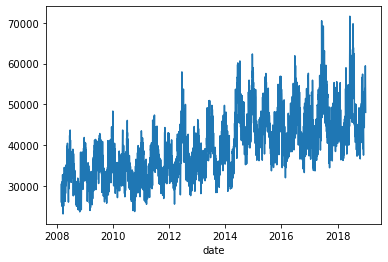

In [61]:
train['date'] = train['datetime'].dt.date
train.groupby('date')['energy'].sum().plot()

In [253]:
train_ts = train[train['year']<=2015].groupby('date')['energy'].sum().reset_index().rename(columns = {'date':'ds','energy':"y"})
val_ts = train[train['year']>2015].groupby('date')['energy'].sum().reset_index().rename(columns = {'date':'ds','energy':"y"})

In [308]:
final_train = train.groupby('date')['energy'].sum().reset_index().rename(columns = {'date':'ds','energy':"y"})

final_future = pd.DataFrame({'ds':test['datetime'].dt.date.unique()}).sort_values('ds')
final_future

,ds
0,2019-01-01
1,2019-01-02
2,2019-01-03
3,2019-01-04
4,2019-01-05
...,...
1091,2021-12-27
1092,2021-12-28
1093,2021-12-29
1094,2021-12-30


# Prophet Exploration

In [67]:
# pip install prophet
# pip install neuralprophet

In [68]:
from prophet import Prophet
from prophet.plot import plot_plotly

from neuralprophet import NeuralProphet

In [542]:
# help(Prophet)
# help(cross_validation)

In [70]:
train.head()

,row_id,datetime,energy,doy_h,year,dom,dow,month,hour,date,daily_energy,dth_ratio
0,1,2008-03-01 00:00:00,1259.985563,061|00,2008,0,5,3,0,2008-03-01,30336.129562,0.041534
1,2,2008-03-01 01:00:00,1095.541500,061|01,2008,0,5,3,1,2008-03-01,30336.129562,0.036113
2,3,2008-03-01 02:00:00,1056.247500,061|02,2008,0,5,3,2,2008-03-01,30336.129562,0.034818
3,4,2008-03-01 03:00:00,1034.742000,061|03,2008,0,5,3,3,2008-03-01,30336.129562,0.034109
4,5,2008-03-01 04:00:00,1026.334500,061|04,2008,0,5,3,4,2008-03-01,30336.129562,0.033832


In [69]:
train[train.energy.isnull()]['month'].value_counts()#.plot()

1     185
8     178
10    173
6     165
7     162
9     161
5     157
12    157
4     154
3     151
11    149
2     108
Name: month, dtype: int64

In [71]:
model = Prophet(yearly_seasonality=25, weekly_seasonality=True, daily_seasonality=True,  changepoint_range=0.9)#,  seasonality_prior_scale=0.05)#,seasonality_prior_scale=15)#,seasonality_mode='multiplicative')#, seasonality_mode='multiplicative')
# model.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')

In [73]:
# help(NeuralProphet)

In [575]:
# # model  = NeuralProphet()# if you're using default variables below.
# model = NeuralProphet(
#     changepoints_range=0.9,#
#     trend_reg=0,
#     trend_reg_threshold=False,
#     yearly_seasonality=True,
#     weekly_seasonality=True,
#     daily_seasonality=True,
#     seasonality_mode="additive",
#     seasonality_reg=0,
#     n_forecasts=1,
#     n_lags=3,
#     num_hidden_layers=1,
#     d_hidden=3,     # Dimension of hidden layers of AR-Net
#      # Sparcity in the AR coefficients
#     learning_rate=None,
#     epochs=40,
#     loss_func="Huber",
#     normalize="auto",  # Type of normalization ('minmax', 'standardize', 'soft', 'off')
#     impute_missing=True 
# )

In [74]:
train_ts.set_index('ds').resample('W').sum().reset_index() # creating a new dataframe created namely  Week with sum  of energy 

,ds,y
0,2008-03-02,57947.864062
1,2008-03-09,203704.786500
2,2008-03-16,207691.800000
3,2008-03-23,208006.594500
4,2008-03-30,201479.011500
...,...,...
405,2015-12-06,346208.363800
406,2015-12-13,341617.187600
407,2015-12-20,353058.773600
408,2015-12-27,353142.236200


In [75]:
model.fit(train_ts)

03:53:09 - cmdstanpy - INFO - Chain [1] start processing
03:54:09 - cmdstanpy - INFO - Chain [1] done processing


In [80]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [82]:
# # Python
# import itertools
# import numpy as np
# import pandas as pd

# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True,changepoint_range=0.9,**params).fit(final_train)  # Fit model with given params
#     df_cv = cross_validation(m,  horizon='730 days', parallel="processes")
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

In [ ]:
# help(model.make_future_dataframe)

In [ ]:
# model.make_future_dataframe(periods=365)

In [ ]:
# from prophet.diagnostics import cross_validation
# df_cv = cross_validation(model,  horizon = '438 days', parallel='processes')

In [ ]:
# df_cv

In [86]:
# from prophet.diagnostics import performance_metrics
# df_p = performance_metrics(df_cv)

In [85]:
# df_p['rmse'].describe()#['horizon']

In [87]:
train_ts

,ds,y
0,2008-03-01 00:00:00,1259.985563
1,2008-03-01 01:00:00,1095.541500
2,2008-03-01 02:00:00,1056.247500
3,2008-03-01 03:00:00,1034.742000
4,2008-03-01 04:00:00,1026.334500
...,...,...
68683,2015-12-31 19:00:00,2563.145000
68684,2015-12-31 20:00:00,2477.116200
68685,2015-12-31 21:00:00,2384.366400
68686,2015-12-31 22:00:00,2351.494600


In [88]:
future = pd.DataFrame({'ds':pd.date_range('2016-01-01','2018-12-31 23:00:00', freq='H'),'y':np.nan}) #  create a dataframe between 2016 and 2018 to test the model 3change to D if date-level
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2016-01-01 00:00:00,2101.469671,1903.543108,2301.723828
1,2016-01-01 01:00:00,2021.055568,1811.192541,2213.269598
2,2016-01-01 02:00:00,1959.740311,1754.872011,2154.710233
3,2016-01-01 03:00:00,1924.300991,1724.055471,2119.849584
4,2016-01-01 04:00:00,1919.748244,1729.761828,2122.722343


In [89]:
# future = pd.DataFrame({'ds':pd.date_range('2016-01-01','2018-12-31 23:00:00', freq='H')}) #change to D if date-level
forecast_train = model.predict(train_ts)
forecast_train[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2008-03-01 00:00:00,1209.264129,1010.205440,1420.379252
1,2008-03-01 01:00:00,1127.400159,925.050827,1318.855579
2,2008-03-01 02:00:00,1064.620838,852.099075,1250.190033
3,2008-03-01 03:00:00,1027.695231,835.650593,1230.425712
4,2008-03-01 04:00:00,1021.624239,822.753315,1229.152155


In [90]:
future.tail()

,ds,y
26299,2018-12-31 19:00:00,NaN
26300,2018-12-31 20:00:00,NaN
26301,2018-12-31 21:00:00,NaN
26302,2018-12-31 22:00:00,NaN
26303,2018-12-31 23:00:00,NaN


In [91]:
forecast['actuals'] = forecast['ds'].map(val_ts.set_index('ds')['y'])
forecast['y'] = forecast['actuals']
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,actuals,y
0,2016-01-01 00:00:00,1918.711112,1903.543108,2301.723828,1918.711112,1918.711112,182.758559,182.758559,182.758559,-74.077671,...,57.136298,199.699932,199.699932,199.699932,0.0,0.0,0.0,2101.469671,2002.2470,2002.2470
1,2016-01-01 01:00:00,1918.715162,1811.192541,2213.269598,1918.715162,1918.715162,102.340406,102.340406,102.340406,-154.878645,...,57.427693,199.791358,199.791358,199.791358,0.0,0.0,0.0,2021.055568,1843.3870,1843.3870
2,2016-01-01 02:00:00,1918.719212,1754.872011,2154.710233,1918.719212,1918.719212,41.021098,41.021098,41.021098,-216.518856,...,57.656119,199.883835,199.883835,199.883835,0.0,0.0,0.0,1959.740311,1735.1178,1735.1178
3,2016-01-01 03:00:00,1918.723263,1724.055471,2119.849584,1918.723263,1918.723263,5.577728,5.577728,5.577728,-252.219763,...,57.820162,199.977328,199.977328,199.977328,0.0,0.0,0.0,1924.300991,1666.1970,1666.1970
4,2016-01-01 04:00:00,1918.727313,1729.761828,2122.722343,1918.727313,1918.727313,1.020931,1.020931,1.020931,-256.970167,...,57.919296,200.071802,200.071802,200.071802,0.0,0.0,0.0,1919.748244,1630.3924,1630.3924


In [92]:
forecast_train['actuals'] = forecast_train['ds'].map(train_ts.set_index('ds')['y'])
forecast_train.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,actuals
0,2008-03-01 00:00:00,1398.605885,1010.205440,1420.379252,1398.605885,1398.605885,-189.341755,-189.341755,-189.341755,-74.077671,...,48.652172,48.652172,-163.916257,-163.916257,-163.916257,0.0,0.0,0.0,1209.264129,1259.985563
1,2008-03-01 01:00:00,1398.585342,925.050827,1318.855579,1398.585342,1398.585342,-271.185183,-271.185183,-271.185183,-154.878645,...,47.642612,47.642612,-163.949150,-163.949150,-163.949150,0.0,0.0,0.0,1127.400159,1095.541500
2,2008-03-01 02:00:00,1398.564799,852.099075,1250.190033,1398.564799,1398.564799,-333.943961,-333.943961,-333.943961,-216.518856,...,46.552197,46.552197,-163.977303,-163.977303,-163.977303,0.0,0.0,0.0,1064.620838,1056.247500
3,2008-03-01 03:00:00,1398.544256,835.650593,1230.425712,1398.544256,1398.544256,-370.849025,-370.849025,-370.849025,-252.219763,...,45.371510,45.371510,-164.000772,-164.000772,-164.000772,0.0,0.0,0.0,1027.695231,1034.742000
4,2008-03-01 04:00:00,1398.523713,822.753315,1229.152155,1398.523713,1398.523713,-376.899473,-376.899473,-376.899473,-256.970167,...,44.090310,44.090310,-164.019617,-164.019617,-164.019617,0.0,0.0,0.0,1021.624239,1026.334500


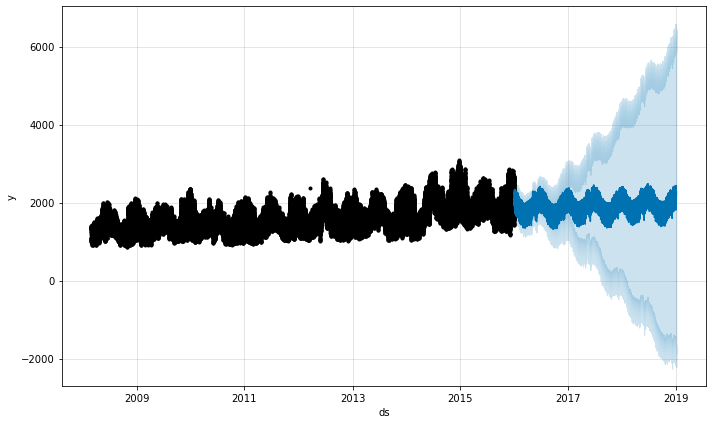

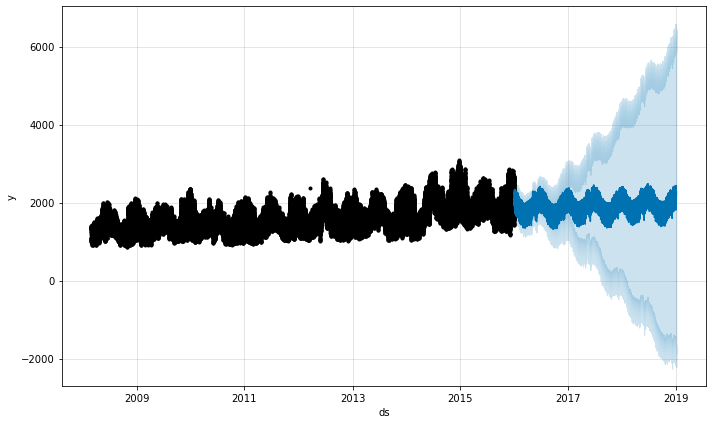

In [93]:
model.plot(forecast)#, uncertainty=True)

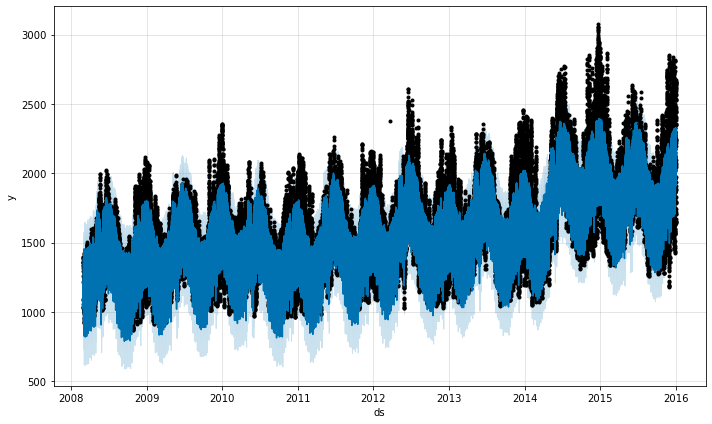

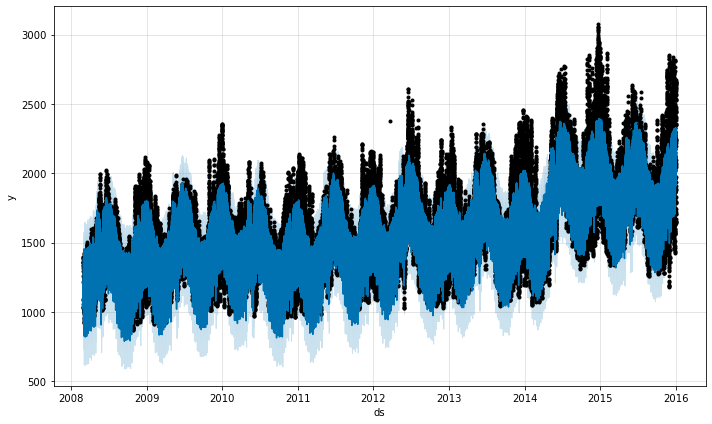

In [94]:
model.plot(forecast_train, uncertainty=True)

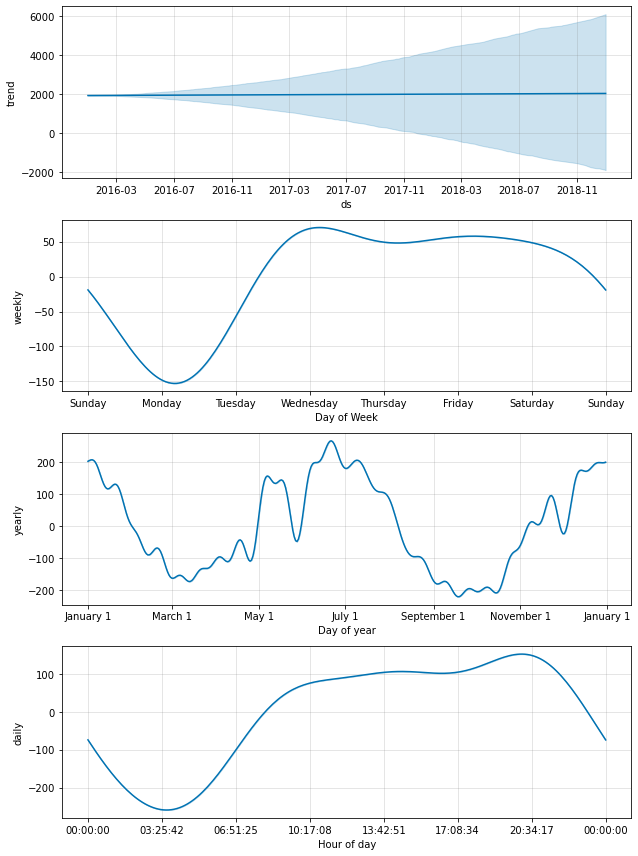

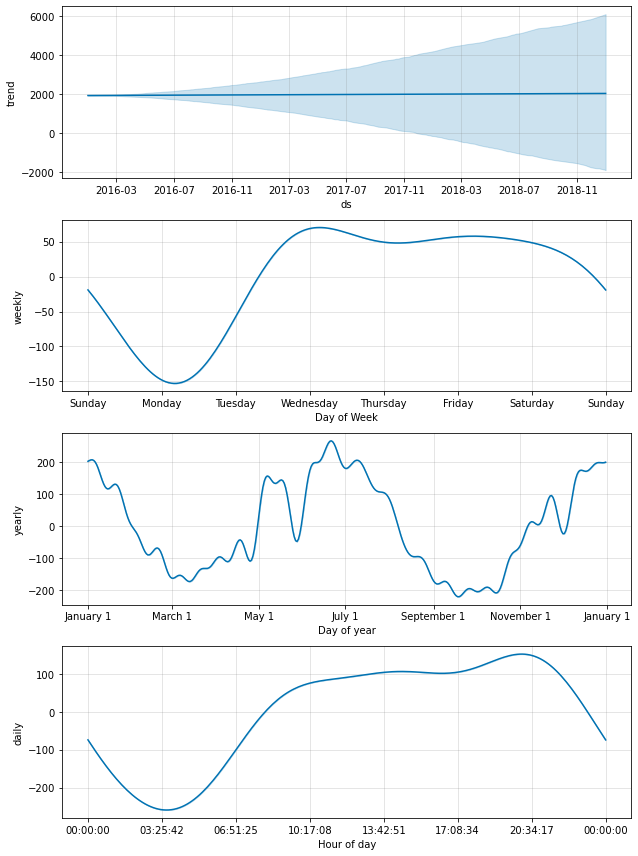

In [95]:
model.plot_components(forecast)

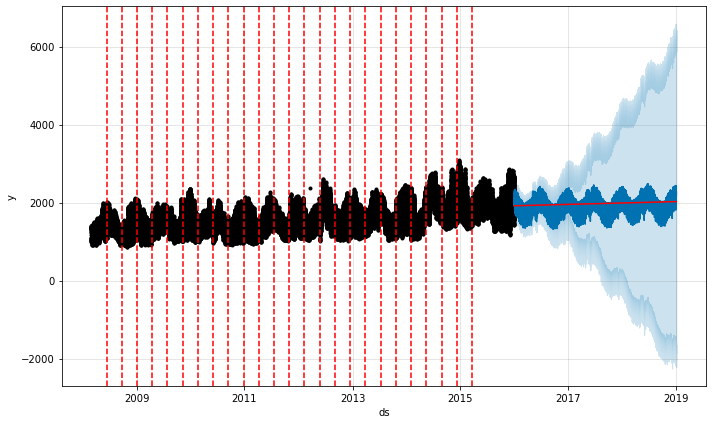

In [96]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

In [97]:
model.changepoints

2424    2008-06-11 17:00:00
4848    2008-09-22 16:00:00
7272    2009-01-03 18:00:00
9696    2009-04-16 18:00:00
12120   2009-07-28 16:00:00
14544   2009-11-08 18:00:00
16968   2010-02-19 23:00:00
19392   2010-06-03 00:00:00
21816   2010-09-14 09:00:00
24240   2010-12-26 07:00:00
26664   2011-04-07 19:00:00
29088   2011-07-19 12:00:00
31511   2011-10-30 09:00:00
33935   2012-02-10 21:00:00
36359   2012-05-23 22:00:00
38783   2012-09-04 05:00:00
41207   2012-12-16 03:00:00
43631   2013-03-29 04:00:00
46055   2013-07-10 03:00:00
48479   2013-10-21 13:00:00
50903   2014-02-01 17:00:00
53327   2014-05-15 14:00:00
55751   2014-08-26 04:00:00
58175   2014-12-07 10:00:00
60599   2015-03-20 10:00:00
Name: ds, dtype: datetime64[ns]

In [98]:
forecast[['actuals','yhat']].isnull().mean() 

actuals    0.020757
yhat       0.000000
dtype: float64

In [99]:
train[train['energy'].isnull()]['datetime'].dt.hour.value_counts().sort_index()

0     77
1     86
2     83
3     74
4     71
5     64
6     98
7     82
8     73
9     95
10    84
11    76
12    76
13    72
14    96
15    79
16    80
17    67
18    86
19    72
20    86
21    76
22    77
23    70
Name: datetime, dtype: int64

In [100]:
train.isnull().mean()

row_id          0.000000
datetime        0.000000
energy          0.020002
doy_h           0.000000
year            0.000000
dom             0.000000
dow             0.000000
month           0.000000
hour            0.000000
date            0.000000
daily_energy    0.000000
dth_ratio       0.020002
dtype: float64

<AxesSubplot:xlabel='ds'>

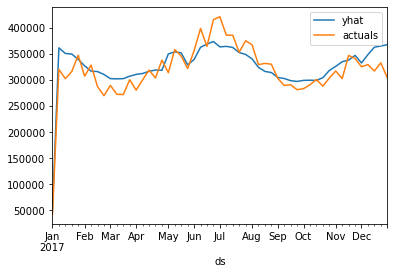

In [101]:
forecast[forecast['ds'].dt.year==2017].set_index('ds')[['yhat','actuals']].resample('W').sum().plot()

<AxesSubplot:xlabel='ds'>

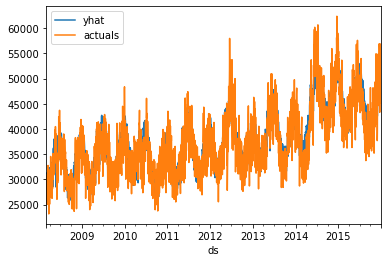

In [102]:
forecast_train.set_index('ds')[['yhat','actuals']].resample('D').sum().iloc[:-1].plot()

In [103]:
forecast.set_index('ds')[['yhat','actuals']].to_clipboard()

In [104]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

print(mean_absolute_error(forecast[forecast['actuals'].notnull()]['actuals'], forecast[forecast['actuals'].notnull()]['yhat']))


mean_squared_error(forecast[forecast['actuals'].notnull()]['actuals'], forecast[forecast['actuals'].notnull()]['yhat'], squared=False)

174.25702615846913


225.36529811221462

In [105]:
print(mean_absolute_error(forecast_train[forecast_train['actuals'].notnull()]['actuals'], forecast_train[forecast_train['actuals'].notnull()]['yhat']))


mean_squared_error(forecast_train[forecast_train['actuals'].notnull()]['actuals'], forecast_train[forecast_train['actuals'].notnull()]['yhat'], squared=False)

117.89333712046587


154.00185083609972

In [107]:
## Prorated Model

In [108]:
hourly_prorata_ratio = train[train['year']<=2015].groupby('hour').dth_ratio.mean()

In [109]:
hourly_prorata_ratio

hour
0     0.040343
1     0.038126
2     0.036806
3     0.036106
4     0.035817
5     0.036180
6     0.037707
7     0.040412
8     0.042412
9     0.043416
10    0.044178
11    0.044797
12    0.045027
13    0.045203
14    0.045331
15    0.045185
16    0.045018
17    0.045292
18    0.045873
19    0.046185
20    0.046126
21    0.046071
22    0.045399
23    0.043107
Name: dth_ratio, dtype: float64

In [110]:
hourly_prorata_ratio.head()

hour
0    0.040343
1    0.038126
2    0.036806
3    0.036106
4    0.035817
Name: dth_ratio, dtype: float64

<AxesSubplot:xlabel='ds'>

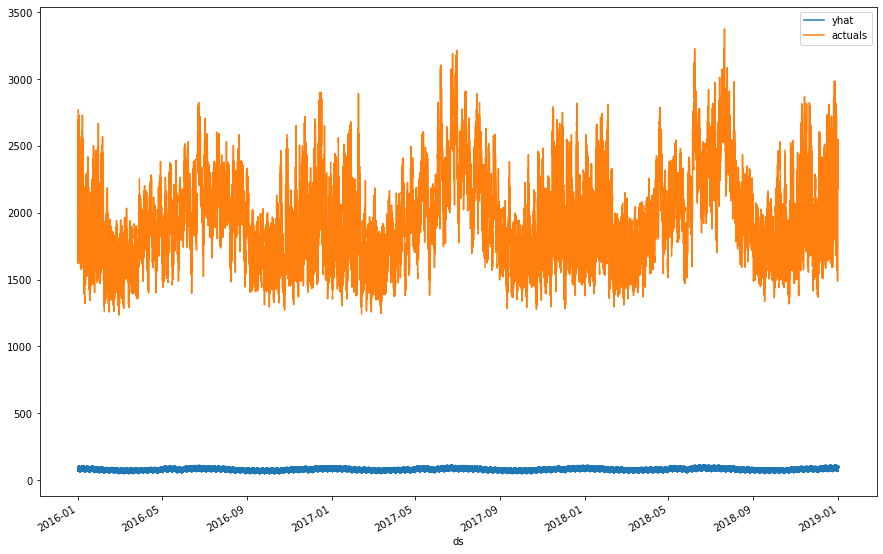

In [111]:
from itertools import product
forecast_prorated = pd.DataFrame()
forecast_prorated['date'] = pd.Series(list(set(product(set(forecast['ds']), set(list(range(24))))))).str.get(0)
forecast_prorated['hour'] = pd.Series(list(set(product(set(forecast['ds']), set(list(range(24))))))).str.get(1)
forecast_prorated['dth_ratio'] = forecast_prorated['hour'].map(hourly_prorata_ratio)
forecast_prorated['yhat_daily'] = forecast_prorated['date'].map(forecast.set_index('ds')['yhat'])
forecast_prorated['yhat'] = forecast_prorated['yhat_daily']*forecast_prorated['dth_ratio']
forecast_prorated['ds'] = forecast_prorated['date'] + pd.to_timedelta(forecast_prorated['hour'], unit='H')
forecast_prorated['actuals'] = forecast_prorated['ds'].map(train.set_index('datetime')['energy'])
forecast_prorated.set_index('ds')[['yhat','actuals']].plot(figsize=(15,10))

In [112]:
forecast_prorated.isnull().mean()

date          0.000000
hour          0.000000
dth_ratio     0.000000
yhat_daily    0.000000
yhat          0.000000
ds            0.000000
actuals       0.021187
dtype: float64

In [113]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(forecast_prorated[forecast_prorated['actuals'].notnull()]['actuals'], forecast_prorated[forecast_prorated['actuals'].notnull()]['yhat'])

1888.6269668840769

## Final Model

In [114]:
model_final = Prophet(yearly_seasonality=25, weekly_seasonality=True, daily_seasonality=True,  changepoint_range=0.9)#,  seasonality_prior_scale=0.05)#,seasonality_prior_scale=15)#,seasonality_mode='multiplicative')#, seasonality_mode='multiplicative')
model_final.fit(final_train)

forecast_final = model_final.predict(final_future)
forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

05:36:50 - cmdstanpy - INFO - Chain [1] start processing
05:38:33 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2019-01-01 00:00:00,2057.810606,1850.772057,2269.856082
1,2019-01-01 01:00:00,1982.788829,1768.042899,2196.884644
2,2019-01-01 02:00:00,1928.108472,1700.418607,2137.812155
3,2019-01-01 03:00:00,1900.444209,1685.796272,2112.779483
4,2019-01-01 04:00:00,1904.968373,1686.229967,2117.492653


In [115]:
hourly_prorata_ratio_final = train.groupby('hour').dth_ratio.mean()

<AxesSubplot:xlabel='ds'>

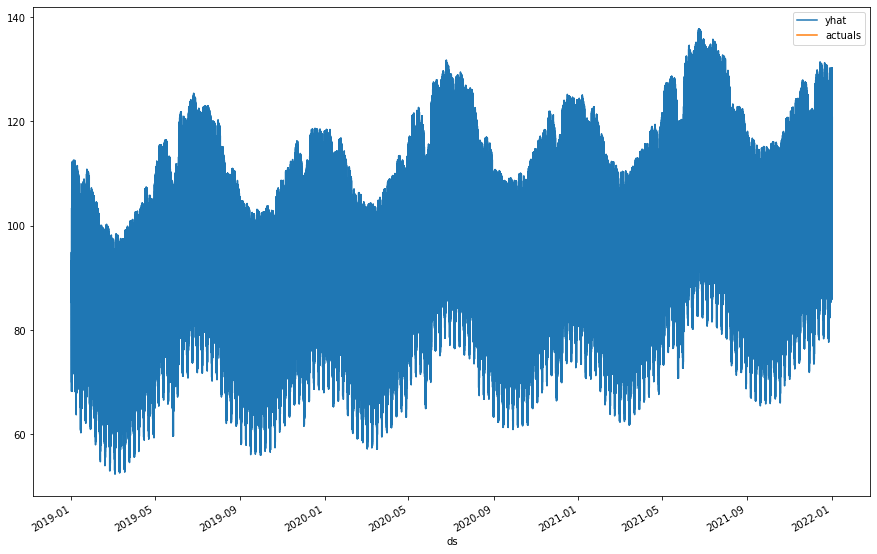

In [116]:
from itertools import product
forecast_prorated_final = pd.DataFrame()
forecast_prorated_final['date'] = pd.Series(list(set(product(set(forecast_final['ds']), set(list(range(24))))))).str.get(0)
forecast_prorated_final['hour'] = pd.Series(list(set(product(set(forecast_final['ds']), set(list(range(24))))))).str.get(1)
forecast_prorated_final['dth_ratio'] = forecast_prorated_final['hour'].map(hourly_prorata_ratio_final)
forecast_prorated_final['yhat_daily'] = forecast_prorated_final['date'].map(forecast_final.set_index('ds')['yhat'])
forecast_prorated_final['yhat'] = forecast_prorated_final['yhat_daily']*forecast_prorated['dth_ratio']
forecast_prorated_final['ds'] = forecast_prorated_final['date'] + pd.to_timedelta(forecast_prorated_final['hour'], unit='H')
forecast_prorated_final['actuals'] = forecast_prorated_final['ds'].map(train.set_index('datetime')['energy'])
forecast_prorated_final.set_index('ds')[['yhat','actuals']].plot(figsize=(15,10))

In [117]:
forecast_prorated_final.isnull().mean()

date          0.0
hour          0.0
dth_ratio     0.0
yhat_daily    0.0
yhat          0.0
ds            0.0
actuals       1.0
dtype: float64

In [118]:
forecast_prorated_final['row_id'] = forecast_prorated_final['ds'].map(test.set_index('datetime')['row_id'])
forecast_prorated_final.sort_values('row_id')

,date,hour,dth_ratio,yhat_daily,yhat,ds,actuals,row_id
48095,2019-01-01 00:00:00,0,0.040312,2057.810606,87.275924,2019-01-01 00:00:00,NaN,94993.0
522855,2019-01-01 01:00:00,0,0.040312,1982.788829,91.575342,2019-01-01 01:00:00,NaN,94994.0
138884,2019-01-01 00:00:00,1,0.038160,2057.810606,92.656028,2019-01-01 01:00:00,NaN,94994.0
215026,2019-01-01 01:00:00,1,0.038160,1982.788829,86.084954,2019-01-01 02:00:00,NaN,94995.0
549627,2019-01-01 02:00:00,0,0.040312,1928.108472,88.935388,2019-01-01 02:00:00,NaN,94995.0
...,...,...,...,...,...,...,...,...
618057,2021-12-31 15:00:00,12,0.045001,2773.993316,127.952434,2022-01-01 03:00:00,NaN,NaN
618509,2021-12-31 16:00:00,11,0.044781,2769.794754,127.057422,2022-01-01 03:00:00,NaN,NaN
621589,2021-12-31 12:00:00,23,0.043035,2759.502119,99.837599,2022-01-01 11:00:00,NaN,NaN
629029,2021-12-31 21:00:00,22,0.045312,2805.723924,129.416031,2022-01-01 19:00:00,NaN,NaN


In [119]:
forecast_prorated_final[['row_id','yhat']].sort_values('row_id').rename(columns={'yhat':'energy'}).to_csv("sub02.csv", index=False)#.isnull().mean()

In [120]:
forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_clipboard(index=False)

In [121]:
forecast_final.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01 00:00:00,2096.012029,1850.772057,2269.856082,2096.012029,2096.012029,-38.201423,-38.201423,-38.201423,-80.522555,...,-63.802844,-63.802844,-63.802844,106.123976,106.123976,106.123976,0.0,0.0,0.0,2057.810606
1,2019-01-01 01:00:00,2096.027265,1768.042899,2196.884644,2096.027265,2096.027265,-113.238436,-113.238436,-113.238436,-164.298480,...,-55.264828,-55.264828,-55.264828,106.324872,106.324872,106.324872,0.0,0.0,0.0,1982.788829
2,2019-01-01 02:00:00,2096.042500,1700.418607,2137.812155,2096.042500,2096.042500,-167.934028,-167.934028,-167.934028,-227.743713,...,-46.718091,-46.718091,-46.718091,106.527776,106.527776,106.527776,0.0,0.0,0.0,1928.108472
3,2019-01-01 03:00:00,2096.057736,1685.796272,2112.779483,2096.057736,2096.057736,-195.613527,-195.613527,-195.613527,-264.136984,...,-38.209161,-38.209161,-38.209161,106.732617,106.732617,106.732617,0.0,0.0,0.0,1900.444209
4,2019-01-01 04:00:00,2096.072972,1686.229967,2117.492653,2096.072972,2096.072972,-191.104599,-191.104599,-191.104599,-268.260479,...,-29.783444,-29.783444,-29.783444,106.939324,106.939324,106.939324,0.0,0.0,0.0,1904.968373


In [122]:
pd.DataFrame({'row_id':test['row_id'],'energy':forecast_final['yhat']}).to_csv("subFinal.csv", index=False)